In [2]:
import pandas as pd 
import numpy as np 
import pingouin as pg 
import matplotlib.pyplot as plt 

In [3]:
# read in the metric files saved as csv
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

#remove subthalamus
cols_to_keep = [col for col in controls.columns if 'Subthal' not in col]
controls = controls[cols_to_keep]
preterms = preterms[cols_to_keep]


### first get all regions pairs, metrics to be evaluated 
tract_names = np.unique(np.array([tract.split('_')[0] for tract in controls.columns[2:]]))
print('Number of evaluated bundles: {}'.format(len(tract_names)))
metrics = np.unique(np.array([tract.partition('_')[-1] for tract in controls.columns[2:]]))

### create pairing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#sanity check: 
if len(preterms) == len(matched):
    print('Number of subject pairs: {}'.format(len(preterms)))
else:
    print('Someting happened with matching')
    
# get age at birth info for the subgrouping
ages = pd.read_csv('../../SourceData/release3_subject_info.tsv', sep='\t')

matched['preterm_birth_age'] = 0.
matched['control_birth_age'] = 0.
for i, row in matched.iterrows():
    matched.at[i, 'preterm_birth_age']  = ages[ages['participant_id '] == row['preterm_ID']+' ']['birth_age '].values[0]
    matched.at[i, 'control_birth_age']  = ages[ages['participant_id '] == row['matched_ID_with_outcome']+' ']['birth_age '].values[0]
    
### creates subgrouped pairs:
extreme_pairs = matched[matched.preterm_birth_age < 32][['preterm_ID','matched_ID_with_outcome']]
moderate_pairs = matched[matched.preterm_birth_age >= 32][['preterm_ID','matched_ID_with_outcome']]

extreme_pairs.rename(columns={'matched_ID_with_outcome': 'matched_ID'}, inplace=True)
moderate_pairs.rename(columns={'matched_ID_with_outcome': 'matched_ID'}, inplace=True)

# sanity check 
if (len(extreme_pairs) + len(moderate_pairs)) == len(matched):
    print('Extreme group: N = {}\nModerate group: N = {}'.format(len(extreme_pairs), len(moderate_pairs)))
else:
    print('Grouping wrong')
    
    

Number of evaluated bundles: 18
Number of subject pairs: 59
Extreme group: N = 33
Moderate group: N = 26


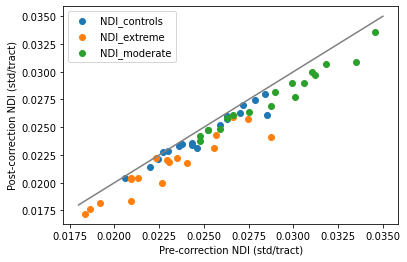

controls: ['M1-Paracentral' 'ParacentralL-ParacentralR' 'S1-Paracentral' 'S1L-S1R']
extreme: ['M1-Paracentral' 'ParacentralL-ParacentralR' 'S1-Paracentral' 'S1L-S1R']
moderate: ['M1-Paracentral' 'ParacentralL-ParacentralR' 'S1-Paracentral']


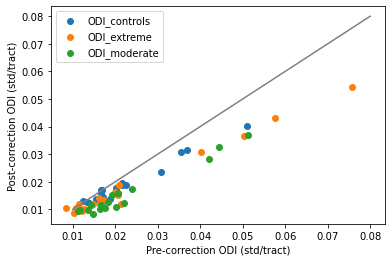

In [6]:
### controls 
#metric = 'ODI'
ps = []


for metric in ['NDI', 'ODI']:
    
    pre_tracts = []
    post_tracts = []

    for tract in tract_names:
    
        pre_tracts.append(np.std(controls[tract+'_'+metric+'_pre'].values))
        post_tracts.append(np.std(controls[tract+'_'+metric+'_post'].values))
     
    if metric == 'ODI':
        print('controls:', tract_names[np.array(pre_tracts) > 0.03])
    
    test1 = pg.ttest(pre_tracts, post_tracts, paired=True)
    ps.append("{:.7f}".format(test1['p-val'].values[0]) )   

    plt.scatter(pre_tracts, post_tracts, label=metric+'_controls')
    ### extreme preterm 

    pre_tracts = []
    post_tracts = []

    for tract in tract_names:
    
        pre_tracts.append(np.std(preterms[preterms.subject_id.isin(extreme_pairs.preterm_ID.values)][tract+'_'+metric+'_pre'].values))
        post_tracts.append(np.std(preterms[preterms.subject_id.isin(extreme_pairs.preterm_ID.values)][tract+'_'+metric+'_post'].values))
    
    if metric == 'ODI':
        print('extreme:', tract_names[np.array(pre_tracts) > 0.03])
        
    test2 = pg.ttest(pre_tracts, post_tracts, paired=True)
    ps.append("{:.7f}".format(test2['p-val'].values[0]))
    
    plt.scatter(pre_tracts, post_tracts, label=metric+'_extreme')

    ### moderate preterm

    pre_tracts = []
    post_tracts = []

    for tract in tract_names:
    
        pre_tracts.append(np.std(preterms[preterms.subject_id.isin(moderate_pairs.preterm_ID.values)][tract+'_'+metric+'_pre'].values))
        post_tracts.append(np.std(preterms[preterms.subject_id.isin(moderate_pairs.preterm_ID.values)][tract+'_'+metric+'_post'].values))
    
    if metric == 'ODI':
        print('moderate:', tract_names[np.array(pre_tracts )> 0.03])
        
    test3 = pg.ttest(pre_tracts, post_tracts, paired=True)
    ps.append("{:.7f}".format(test3['p-val'].values[0])) 
    
    plt.scatter(pre_tracts, post_tracts, label=metric+'_moderate')
    
    plt.xlabel('Pre-correction {} (std/tract)'.format(metric))
    plt.ylabel('Post-correction {} (std/tract)'.format(metric))
    
    if metric == 'NDI':
        plt.plot(np.linspace(0.018,0.035), np.linspace(0.018,0.035), c='gray')
    else:
        plt.plot(np.linspace(0.01,0.08), np.linspace(0.01,0.08), c='gray')
        
    plt.legend()
    plt.show()

reject, pvals_corr = pg.multicomp(np.array(ps).astype(np.float32), method='fdr_bh')

